The different data types showed over a 30-fold difference in the percent of heterozygous SNPs located within regions (genes or peaks) that displayed ASE. We examined technical aspects of ASE analysis in ChIP-Seq and ATAC-Seq peaks, in order to elucidate potential experimental and/or biological reasons underlying these observed differences. 

In [41]:
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(vioplot))

In [1]:
sample_table = read.csv("/home/paola/Family1070/private_output/PCA_chipseq/fam1070_data_plus_production-4.csv") 
sample_table= subset(sample_table,  Data_type!="GRO-Seq" & Data_type!="ChIP-Seq SRF" & Data_type!="RNA-Seq")
sample_table= subset(sample_table, Subject!="Pool")
sample_table$Tissue = sample_table$Cell_type
sample_table$subject = sample_table$Subject


In [2]:
pipeline = "/home/paola/Family1070/private_output/ASE_chip/pipeline"

In [3]:
get_coverage= function(mark, tissue, subject, pipeline, Median=FALSE){
mbased_folder = paste(pipeline,  mark, "analysis", tissue, subject, "mbased", sep = "/")
in_file       = paste(mbased_folder, "/", subject, "_mbased_input.tsv", sep = "" )
inf = read.table(in_file, header=T)
r = inf$totalFeatureCount
   if(Median == TRUE) {r = median(r)}
    return ( r )
}

In [4]:
test_marks = c('ATAC', 'H3K27AC', 'NKX25')
li = list()
for (mark in test_marks ){
     mark_dir = paste(pipeline,  mark,"analysis", sep="/")
    for (tissue in list.files(mark_dir)){
        pa = paste(tissue, mark, sep="_")
        val = c()
        for (subject in list.files(paste(mark_dir,  tissue, sep="/"))){
            if(subject %in% unique(sample_table$subject)){
            val[subject] =  get_coverage(mark, tissue, subject, pipeline=pipeline, Median=TRUE)
                }
        }
        li[[pa]] = val
    }
}

In [5]:
test_marks = c('ATAC', 'H3K27AC', 'NKX25')
lili = list()
for (mark in test_marks ){
     mark_dir = paste(pipeline,  mark,"analysis", sep="/")
    for (tissue in list.files(mark_dir)){
        pa = paste(tissue, mark, sep="_")
        val = list()
        for (subject in list.files(paste(mark_dir,  tissue, sep="/"))){
            if(subject %in% unique(sample_table$subject)){
            val[[subject]] =  get_coverage(mark, tissue, subject, pipeline=pipeline, Median=FALSE)
                }
        }
        lili[[pa]] = val
    }
}

In [6]:
unlili = lapply(lili, unlist)

In [7]:
names(unlili)

[1] "iPSC_ATAC"       "iPSC-CM_ATAC"    "iPSC_H3K27AC"    "iPSC-CM_H3K27AC"
[5] "iPSC-CM_NKX25"

In [8]:
sample_table$assy_tissue = with(sample_table, paste(Data_type,Tissue, sep="_" ))

In [9]:
sp = split(sample_table, sample_table$assy_tissue)

In [10]:
mapre = lapply(sp, function(x) aggregate(Uniquely_mapped_and_filtered_reads ~ Subject, x, sum)[,2]/1e6)

In [11]:
#mapre[[1]] =mapre[[1]]  [-(4:5)]

In [12]:
effi = lapply(sp, function(x) aggregate(ChIP.Seq_ATAC.Seq_FRiP ~ Subject, x, mean, na.rm=T)[,2]*100)

In [13]:
min(unlist(lapply(li, min)))
max(unlist(lapply(li, max)))

[1] 9

[1] 88

In [14]:
setwd(pipeline)

In [15]:
pcas = list()
efs  = list()
for( i in 1:5){
file = paste( "results/", names(li)[i], "_ase_snv.txt", sep="")
res = read.table(file, header=T)

sps = split(res, res$subject)
pcas[[names(li)[i]]] = sapply(sps, function(x) sum(p.adjust(x$binomialPValue, method= "BH")<0.05 , na.rm=T) / nrow(x))
efs [[names(li)[i]]] = sapply(sps, function(x) median(x$major_allele_freq, na.rm=T))
    }

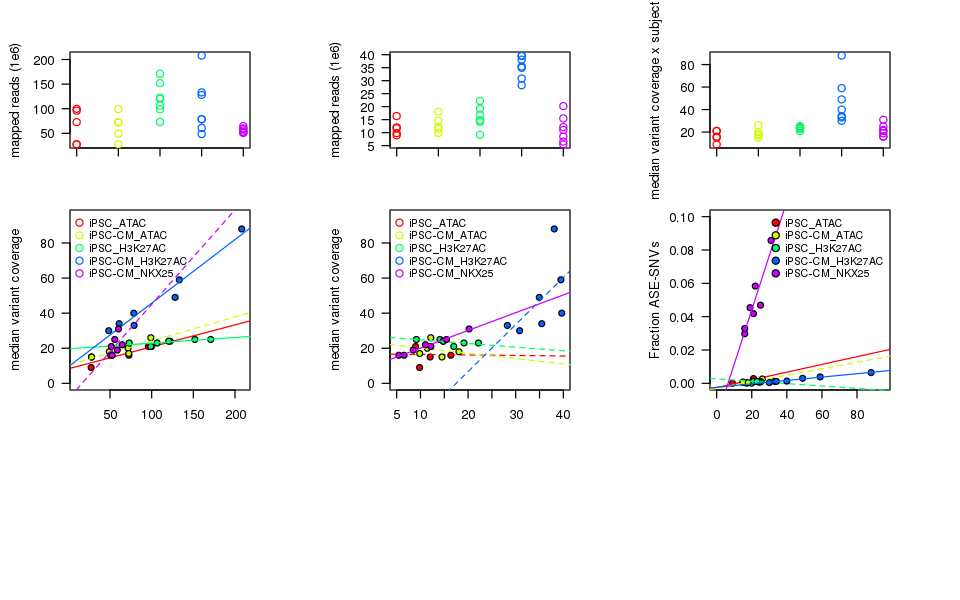

In [21]:
options(repr.plot.width=8, repr.plot.height=5)
collect = data.frame()
#par(mar=c(4,4,1,2))
#pdf("../../Figures/ASE_coverage_compare_3.pdf")
par(mfrow=c(3,3), pin=c(1.5, 0.8))



stripchart(mapre, col = rainbow(5), las=2, ylab="mapped reads (1e6)", vertical=T, pch=1, group.names=NA , cex=1.2)
stripchart(effi, col = rainbow(5), las=2, ylab="mapped reads (1e6)", vertical=T, pch=1, group.names=NA , cex=1.2)
stripchart(li, col=rainbow(5), las=2, ylab= "median variant coverage x subject", vertical=T, pch=1 , cex=1.2, group.names=NA)
par( pin=c(1.5, 1.5))

plot(NA, xlim=c(10,210), ylim=c(0,95),xlab="mapped reads (1e6)" , ylab= "median variant coverage", las=1)
for(i in 1:5){
    points(mapre[[i]], li[[i]], bg=rainbow(5)[i], pch=21)
    l = lm(li[[i]]~mapre[[i]])
    abline( l , col=rainbow(5)[i], lty= c(2,1)[(summary( l)[[4]][2,4]<0.05)+1])
    
    collect[1,i] = summary( l)[[4]][2,4]
    
}
legend("topleft", pch=1, col=rainbow(5), legend =names(li), bty="n", cex=0.8 , pt.cex=1.2)


plot(NA, xlim=c(5,40), ylim=c(0,95),xlab="mean FrIP (%)" , ylab= "median variant coverage", las=1)
for(i in 1:5){
    points(effi[[i]], li[[i]], bg=rainbow(5)[i], pch=21)
    l = lm(li[[i]]~effi[[i]])
    abline( l , col=rainbow(5)[i], lty= c(2,1)[(summary( l)[[4]][2,4]<0.05)+1])
    collect[2,i] = summary( l)[[4]][2,4]
}
legend("topleft", pch=21, col=rainbow(5), legend =names(li), bty="n", cex=0.8 , pt.cex=1.2)



plot(NA, ylim=c(0, 0.1), xlim=c(0,95),ylab="Fraction ASE-SNVs" , xlab= "median SNV coverage", las=1)

for(i in 1:5){
    points(li[[i]], pcas[[i]], bg=rainbow(5)[i], pch=21)
    l = lm(pcas[[i]]~li[[i]] )
    abline( l, col=rainbow(5)[i], lty= c(2,1)[(summary( l)[[4]][2,4]<0.05)+1])
    collect[3,i] = summary( l)[[4]][2,4]
}
legend("topright", pch=21, pt.bg=rainbow(5), legend =names(li), bty="n", cex=0.8, pt.cex=1.2)
#dev.off()


In [22]:
### Pvalues of the linear regressions
colnames(collect) = names(li)
collect

iPSC_ATAC  iPSC-CM_ATAC iPSC_H3K27AC iPSC-CM_H3K27AC iPSC-CM_NKX25
1 0.04208566 0.05202317   0.04827629   1.166590e-04    2.285225e-01 
2 0.97916911 0.70834938   0.13868144   1.816758e-01    2.849677e-05 
3 0.02912178 0.12217810   0.11955702   1.303704e-05    3.454654e-03

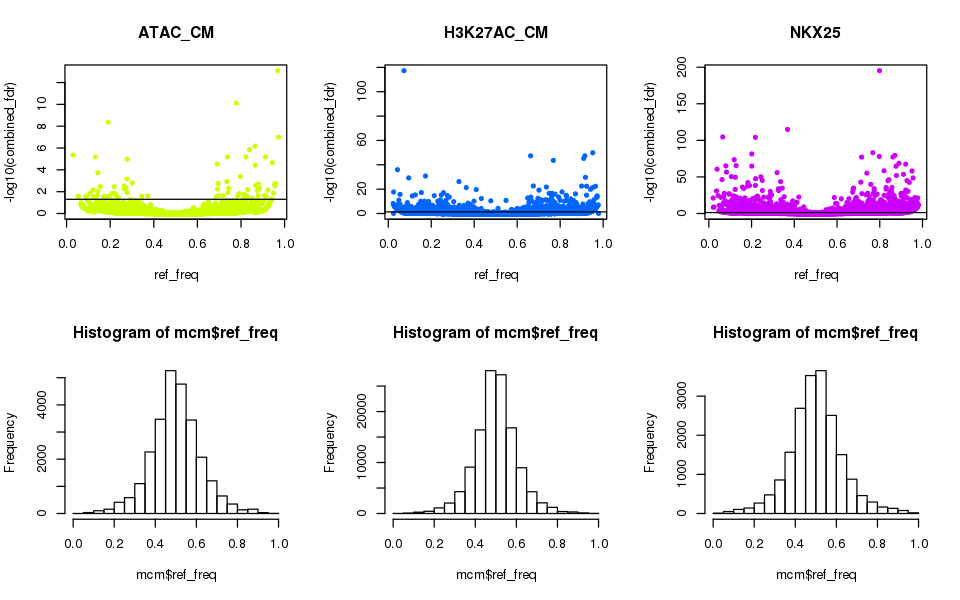

In [23]:
par(mfcol=c(2,3))
marks = c('ATAC_CM', 'H3K27AC_CM', 'NKX25')
for( i in 1:3){
j = c(2,4,5)[i]
mcm = read.table(paste("../correlationWithBeta/ASE.tested", marks[i], "txt", sep="."), header=T)
    plot(-log10(combined_fdr)~ ref_freq, mcm, pch = 20, col = rainbow(5)[j], main =marks[i] )
    abline (h = 1.3)
hist(mcm$ref_freq)    
    }


In [19]:
marks = c('ATAC_CM', 'H3K27AC_CM', 'NKX25')

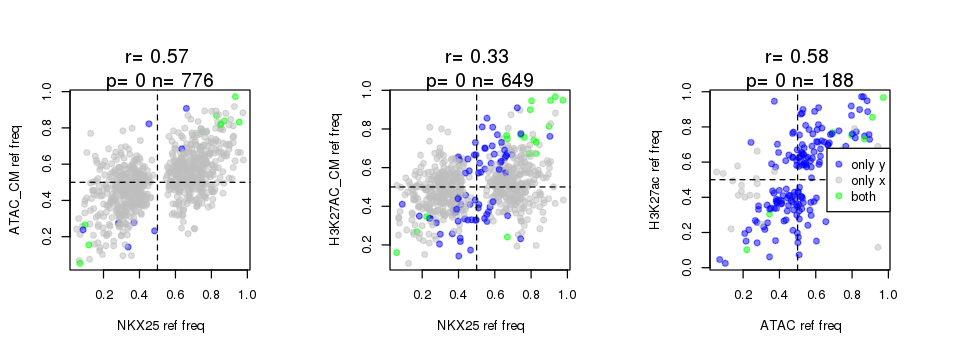

In [26]:
options(repr.plot.width=8, repr.plot.height=3)
#pdf("../../Figures/ASE_effects_correlation.pdf")
nkx = mcm = read.table(paste("../correlationWithBeta/ASE.tested", "NKX25", "txt", sep="."), header=T)
 
t1 = list()
t2 = list()

par(mfrow=c(1,3), pin=c(1.5, 1.5))
for(i in 1:2){
atac = read.table(paste("../correlationWithBeta/ASE.tested", marks[i], "txt", sep="."), header=T)

mm = merge(nkx[,c('variantID', 'combined_fdr','ref_freq')],atac[,c('variantID', 'combined_fdr','ref_freq')] , by=1, all=T)

t1[[marks[i]]] = table(!is.na(mm$ref_freq.x), !is.na(mm$ref_freq.y))

comm = merge(nkx[,c('variantID', 'combined_fdr','ref_freq')],atac[,c('variantID', 'combined_fdr','ref_freq')] , by=1)

t2[[marks[i]]] = table(comm$combined_fdr.x<0.05, comm$combined_fdr.y<0.05)

sig = comm[comm$combined_fdr.x<0.05 | comm$combined_fdr.y<0.05,]
    
sig$ovp = paste(as.numeric(sig$combined_fdr.x<0.05) , as.numeric(sig$combined_fdr.y<0.05 ), sep="")
colors= alpha(c('blue', "gray", "green"),0.5)
    
plot(ref_freq.y~ ref_freq.x, sig , col = colors [as.numeric(as.factor(sig$ovp ))] , pch=19,
      xlab = "NKX25 ref freq", ylab = paste(marks[i], "ref freq"))
abline(v=0.5, h=0.5, lty=2)
co = cor.test(sig$ref_freq.x, sig$ref_freq.y)
mtext(paste("r=",round(co$estimate , 2), "\np=", signif(co$p.value,3), "n=", nrow(sig)) ) 
}

h3k  = atac
atac = read.table(paste("../correlationWithBeta/ASE.tested", marks[1], "txt", sep="."), header=T)
mm   = merge(atac[,c('variantID', 'combined_fdr','ref_freq')],h3k[,c('variantID', 'combined_fdr','ref_freq')] , by=1, all=T)
t1[["atac-h3k"]] = table(!is.na(mm$ref_freq.x), !is.na(mm$ref_freq.y))

comm = merge(atac[,c('variantID', 'combined_fdr','ref_freq')],h3k[,c('variantID', 'combined_fdr','ref_freq')] , by=1)
t2[["atac-h3k"]] = table(comm$combined_fdr.x<0.05, comm$combined_fdr.y<0.05)

sig = comm[comm$combined_fdr.x<0.05 | comm$combined_fdr.y<0.05,]
    sig$ovp = paste(as.numeric(sig$combined_fdr.x<0.05) , as.numeric(sig$combined_fdr.y<0.05 ), sep="")
colors= alpha(c('blue', "gray", "green"),0.5)
plot(ref_freq.y~ ref_freq.x, sig , col = colors [as.numeric(as.factor(sig$ovp ))] , 
     pch=19,
    ylab = "H3K27ac ref freq", xlab ="ATAC ref freq" )
abline(v=0.5, h=0.5, lty=2)
co = cor.test(sig$ref_freq.x, sig$ref_freq.y)
mtext(paste("r=",round(co$estimate , 2), "\np=", signif(co$p.value,3), "n=", nrow(sig)) ) 
#plot.new()
legend("right", pch=19, col= colors, legend = c('only y' ,'only x', 'both'))
#dev.off()

### Coverage of ASE varinats across the different assays

In [38]:
v1 = c(8, 16, 32, 64, 128 , 256)
v2 = seq(0.5,1, 0.05)

In [39]:
li = li2 = fc = ef = list()

par(mfrow=c(3,1))
marks = c('ATAC_IPSC', 'ATAC_CM', 'H3K27AC_IPSC', 'H3K27AC_CM', 'NKX25')

i=1
#plot(NA, xlim=c(0,2000), ylim=c(0,1))
for( i in 1:length(marks)){
j = c(5, 2,4)[i]
mcm = read.table(paste("../correlationWithBeta/ASE.tested", marks[i], "txt", sep="."), header=T)
mcm$freq = abs(mcm$ref_freq -(1*(mcm$ref_freq<0.5)))

li[[i]] = sapply(v1, function(x) sum(mcm$rawDepth >= x) / nrow(mcm))
li2[[i]] = sapply(v2, function(x) sum(mcm$freq >= x) / nrow(mcm))
fc[[i]] = mcm$rawDepth
ef[[i]] = mcm$freq
    
    #fc[[i]] = ecdf(mcm$rawDepth)
#ef[[i]] = ecdf(mcm$freq)
}

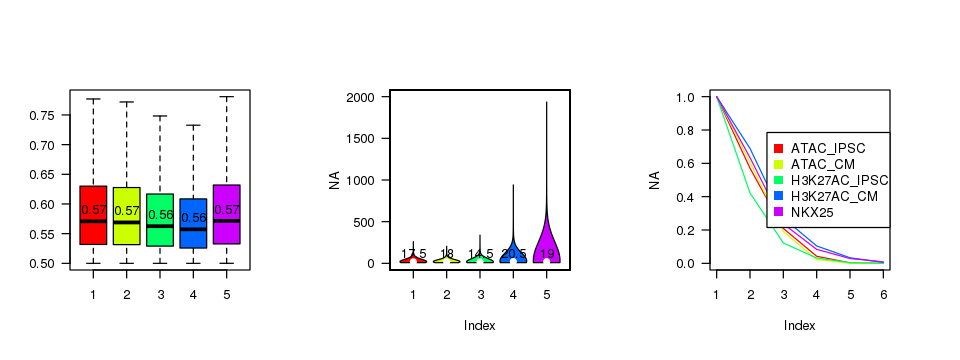

In [42]:
par(mfrow=c(1,3), pin=c(1.5, 1.5))


boxplot(ef, col = rainbow(5), outline=F, las=1)
text(1:5, sapply(ef, median) + 0.02, round(sapply(ef, median),2) )
# boxplot(fc, col = rainbow(5), outline=F)
# text(1:5, sapply(fc, median) + 3, round(sapply(fc, median),2) )

plot(NA, xlim=c(0.5,5.5), ylim=c(0,2000), las=1)
invisible(lapply(1:5, function(x) vioplot(fc[[x]], col=rainbow(5)[x], add=T, at = x)))
    text(1:5, sapply(fc, median) + 100, round(sapply(fc, median),2) )

    
plot(NA, xlim=c(1,6), ylim= c(0,1), las=1)
for (i in 1:5){
    
 j = c(5, 2,4)[i]   
    lines(li[[i]]~c(1:6), col = rainbow(5)[i])
}
    
    legend("right", pch=15, col= rainbow(5), legend= marks, pt.cex=1.5)


### Calculate number of ASE and effect size from samples SNPs with the same coverage

Given that the distribution of SNV coverage varied across the different data types (Supplementary Fig. 4g), we examined if the higher efficiency of the NKX2-5 ChIP-Seq assay was due a greater fraction of SNVs having high coverage. We performed a simulation where we sampled 100 SNVs from the iPSC-ATAC-Seq list (as a reference distribution) and sampled an equal number of SNVs with the same coverage in the remaining datasets, and repeated 100 times. For each sampling, we calculated the number of SNVs with significant ASE at FDR<10% and the average allele frequency of the most represented allele (effect sizes). This analysis showed that independently from coverage, the fraction of ASE-SNVs in NKX2-5 ChIP-Seq was more than 10 fold greater than the other assays, which was consistent with higher observed effect sizes.

In [28]:
nkx =  read.table(paste("../correlationWithBeta/ASE.tested", "NKX25", "txt", sep="."), header=T)
h3k =  read.table(paste("../correlationWithBeta/ASE.tested", "H3K27AC_CM", "txt", sep="."), header=T)
ata =  read.table(paste("../correlationWithBeta/ASE.tested", "ATAC_CM", "txt", sep="."), header=T)


In [30]:
h3i =  read.table(paste("../correlationWithBeta/ASE.tested", "H3K27AC_IPSC", "txt", sep="."), header=T)
ati =  read.table(paste("../correlationWithBeta/ASE.tested", "ATAC_IPSC", "txt", sep="."), header=T)

In [31]:
nkx$freq = abs(nkx$ref_freq -(1*(nkx$ref_freq<0.5)))
h3k$freq = abs(h3k$ref_freq -(1*(h3k$ref_freq<0.5)))
ata$freq = abs(ata$ref_freq -(1*(ata$ref_freq<0.5)))
h3i$freq = abs(h3i$ref_freq -(1*(h3i$ref_freq<0.5)))
ati$freq = abs(ati$ref_freq -(1*(ati$ref_freq<0.5)))

In [32]:
n    = 100
c    = 100
lili = effe = matrix(NA, nrow=100, ncol=5)
ll   = list(ata, h3i, h3k, nkx)

for( i in 1:c){
ids = sample(ata$variantID, n)
cov = ati$rawDepth[ati$variantID %in% ids]

cov = cov[(round(cov) %in% round(nkx$rawDepth)) &  round(cov) %in% round(h3k$rawDepth)
         &  round(cov) %in% round(h3i$rawDepth) &  round(cov) %in% round(ata$rawDepth)]    

es        = ati$freq[ati$variantID %in% ids]
pvs       = ati$combined_pv[ati$variantID %in% ids]
lili[i,1] = sum(p.adjust(pvs, method="BH")< 0.1) 
effe[i,1] = mean(es, na.rm=T)
    
    

    for ( m in 1:4){
tab  = ll[[m]]
samp = sapply( cov, function(x) sample(tab$variantID[round(tab$rawDepth) == round(x)],1))
 
sub = subset(tab, variantID %in% samp)
        
        
lili[i,m+1]  = sum(p.adjust(sub$combined_pv, method="BH")< 0.1) 
effe[i,m+1]  = mean(sub$freq, na.rm=T)

    
  }  
    
    }

In [33]:
marks = c('ATAC_IPSC', 'ATAC_CM', 'H3K27AC_IPSC', 'H3K27AC_CM', 'NKX25')
colnames(lili) = colnames(effe) = marks

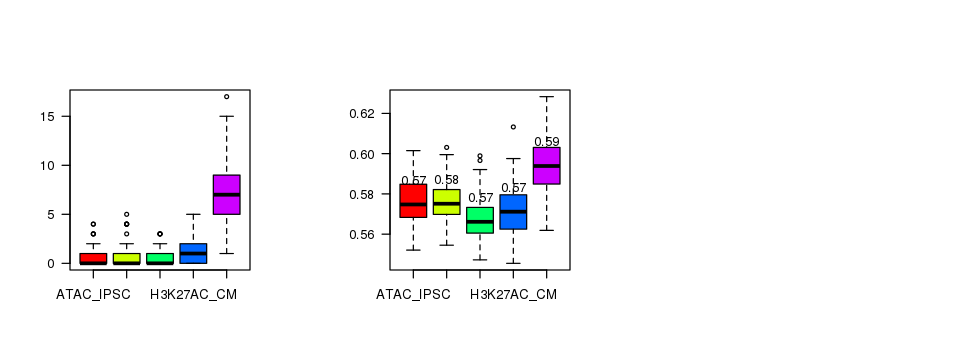

In [36]:
#pdf("../../Figures/ASE_effects_simulations.pdf")
par(mfrow=c(1,3), pin=c(1.5, 1.5))
boxplot(lili, col=rainbow(5), las=1)

boxplot(effe, col=rainbow(5), las=1)
text(1:5, apply(effe,2, median) + 0.012, round(apply(effe,2, median),2) )
#dev.off()

In [208]:
colMeans(lili)

ATAC_IPSC      ATAC_CM H3K27AC_IPSC   H3K27AC_CM        NKX25 
        0.37         0.53         0.93         0.59         7.66